In [1]:
"""
Produce a CMB map from 3 frequencies (90, 150, 220). 
Foregrounds: All extragalactic (tSZ, kSZ, CIB, RG) foregrounds simulated as a simple Guassian using SPT-SZ George et al. 2015 data.
"""

'\nProduce a CMB map from 3 frequencies (90, 150, 220). \nForegrounds: All extragalactic (tSZ, kSZ, CIB, RG) foregrounds simulated as a simple Guassian using SPT-SZ George et al. 2015 data.\n'

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'
try:
    import os
    rc('text.latex',preamble=r'\usepackage{%s/apjfonts}' %(str(os.getcwd())))
except:
    pass

In [3]:
import argparse, sys, numpy as np, scipy as sc, warnings, os, healpy as H
sys.path.append('/Users/sraghunathan/Research/SPTPol/analysis/git/tools/')
#or look into https://github.com/sriniraghunathan/tools
import flatsky, tools, misc
import ilc, foregrounds as fg

import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

In [4]:
#some constants
h=6.62607004e-34 #Planck constant in m2 kg / s
k_B=1.38064852e-23 #Boltzmann constant in m2 kg s-2 / K-1
Tcmb = 2.73 #Kelvin

In [5]:
#params
paramfile = 'params.ini'
freqarr = [95, 150, 220]#, 270]
beamarr= [2.3, 1.5, 1.0]#, 0.8]
noisearr_T = [2.0, 2.0, 6.9]#, 16.7]
#elkneearr_T = [2154., 4364., 7334.]#, 7308.]
elkneearr_T = [-1,-1,-1]#, -1]
alphakneearr_T = [3.5, 3.5, 3.5]#, 3.5]

noisearr_P = [2.9, 2.8, 9.8]#, 23.6]
elkneearr_P = [700., 700., 700.]#, 700.]
alphakneearr_P = [1.4, 1.4, 1.4]#, 1.4]
'''
freqarr = [90, 150, 220]#, 270]
beamarr= [3.5,2.0,1.4]#, 0.8]
noisearr = [1.0, 1.0, 1.0]
elkneearr = [-1, -1, -1, -1]
alphakneearr = [0, 0, 0, 0]
'''

freqcalib_fac = None
final_comp = 'CMB'
TParr = ['T']#, 'P']
ignore_fg = [final_comp]
verbose = 0
#for plotting
colordic = {95: 'darkblue', 150: 'green', 220: 'goldenrod', 270: 'darkred'}

In [6]:
# read and store param dict
param_dict = misc.fn_get_param_dict(paramfile)
el = np.arange(param_dict['lmax'])

In [7]:
#collect beam and noise into a dic; elknee and alpha into a dic
beam_noise_dic = {}
elknee_dic = {}
for TP in TParr:
    beam_noise_dic[TP] = {}
    elknee_dic[TP] = {} 
    if TP == 'T':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_T, elkneearr_T, alphakneearr_T
    elif TP == 'P':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_P, elkneearr_P, alphakneearr_P

    for (freq, beam, noise, elknee, alphaknee) in zip(freqarr, beamarr, noisearr, elkneearr, alphakneearr):
        beam_noise_dic[TP][freq] = [beam, noise]
        elknee_dic[TP][freq] = [elknee, alphaknee]

#final effective beam for the ILC map
opbeam = beam_noise_dic['T'][150][0]

In [8]:
#get beam deconvolved noise nls
nl_dic_beam_deconv = {}
nl_dic = {}
for TP in TParr:
    nl_dic[TP]={}
    nl_dic_beam_deconv[TP]={}    
    for freq in freqarr:
        beamval, noiseval = beam_noise_dic[TP][freq]
        elknee, alphaknee = elknee_dic[TP][freq]

        #nl after deconlving beam for covariance calculation
        nl = misc.get_nl(noiseval, el, beamval, elknee = elknee, alphaknee = alphaknee)
        nl[el<=param_dict['lmin']] = 0.
        nl[nl == 0.] = np.min(nl[nl!=0.])/1e3
        nl_dic_beam_deconv[TP][freq] = nl 

        #nl w/o beam for noise sims
        nl = misc.get_nl(noiseval, el, beamval, elknee = elknee, alphaknee = alphaknee, use_beam_window = 0)
        nl[el<=param_dict['lmin']] = 0.
        nl[nl == 0.] = np.min(nl[nl!=0.])/1e3
        nl_dic[TP][freq] = nl
        
print(nl_dic['T'].keys())

dict_keys([95, 150, 220])


dict_keys([95, 150, 220, 'effective'])


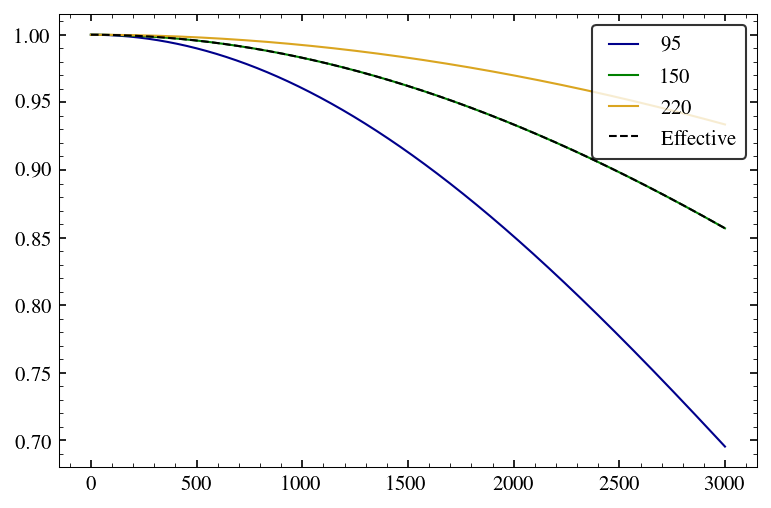

In [9]:
#get beams
bl_dic = misc.get_beam_dic(freqarr, beam_noise_dic['T'], param_dict['lmax'], opbeam = opbeam)
print(bl_dic.keys())
if (1):
    for freq in freqarr:
        plot(bl_dic[freq], color = colordic[freq], label = freq)
    plot(bl_dic['effective'], 'k--', label = r'Effective')
    legend(loc = 1)

In [10]:
#get the CMB, noise, and foreground covriance
try:
    ignore_fg = param_dict['ignore_fg']
except:
    ignore_fg = []

ignore_fg.append(final_comp) #the required component need not go into the covariance matrix.

cl_dic = {}
for TP in TParr:
    if TP == 'T':
        el, cl_dic[TP] = ilc.get_covariance_dic(param_dict, freqarr, nl_dic = nl_dic_beam_deconv['T'], ignore_fg = ignore_fg)
    elif TP == 'P':
        el, cl_dic[TP] = ilc.get_covariance_dic\
                    (param_dict, freqarr, nl_dic = nl_dic_beam_deconv['P'], ignore_fg = ignore_fg, pol = 1, \
                    pol_frac_per_cent_dust = param_dict['pol_frac_per_cent_dust'], \
                    pol_frac_per_cent_radio = param_dict['pol_frac_per_cent_radio'], \
                    pol_frac_per_cent_tsz = param_dict['pol_frac_per_cent_tsz'], \
                    pol_frac_per_cent_ksz = param_dict['pol_frac_per_cent_ksz'], \
                    )
print(cl_dic['T'].keys())

dict_keys([(95, 95), (95, 150), (95, 220), (150, 95), (150, 150), (150, 220), (220, 95), (220, 150), (220, 220)])


In [11]:
#foreground only to create Gaussian realisations of foreground maps
cl_fg_dic = {}
for freq1 in sorted(freqarr):
    el, cl_tSZ = fg.get_foreground_power_george_2015('tSZ', freq1 = freq1, freq2 = freq1)
    el, cl_kSZ = fg.get_foreground_power_george_2015('kSZ', freq1 = freq1, freq2 = freq1)
    el, cl_DGPo = fg.get_foreground_power_george_2015('DG-Po', freq1 = freq1, freq2 = freq1)
    el, cl_DGclus = fg.get_foreground_power_george_2015('DG-Cl', freq1 = freq1, freq2 = freq1)
    el, cl_RG = fg.get_foreground_power_george_2015('RG', freq1 = freq1, freq2 = freq1)
    cl_fg = cl_tSZ + cl_kSZ + cl_DGPo + cl_DGclus + cl_RG

    cl_fg = np.concatenate( (np.zeros(param_dict['lmin']), cl_fg) )
    el = np.arange(len(cl_fg))

    cl_fg = cl_fg[:param_dict['lmax']]
    el = el[:param_dict['lmax']]

    cl_fg_dic[freq1] = cl_fg


In [12]:
#read Cls now
lmax = param_dict['lmax']
camb_file = param_dict['Dlfile_len']
el_camb = np.loadtxt(camb_file, usecols = [0])
dl_camb = np.loadtxt(camb_file, usecols = [1,2,3,4])
el_camb = el_camb[:lmax]
dl_camb = dl_camb[:lmax]

cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T

print(len(el_camb))

3000


Text(0, 0.5, '$C_{\\ell}$')

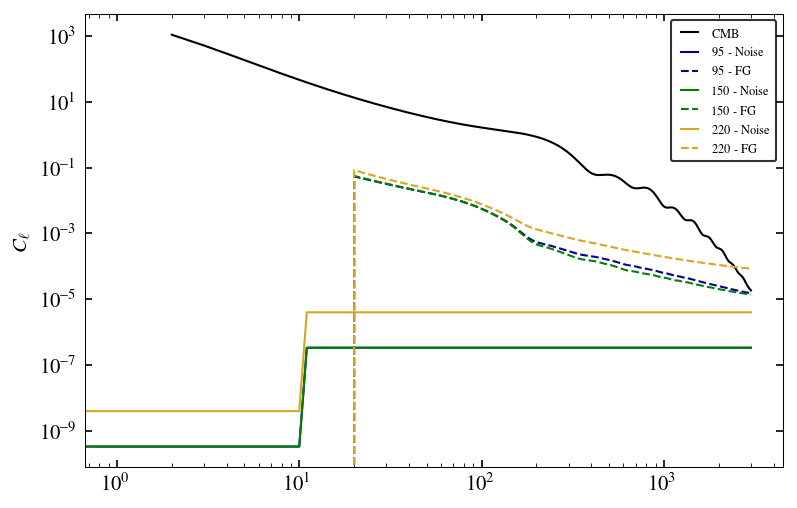

In [13]:
#plot
ax =subplot(111, yscale = 'log', xscale = 'log')
plot(el_camb, cl_TT, 'k-', label = r'CMB')
for freq in nl_dic['T']:
    plot(el, nl_dic['T'][freq], label = r'%s - Noise' %(freq), color = colordic[freq])    
    plot(el, cl_fg_dic[freq], label = r'%s - FG' %(freq), color = colordic[freq], ls = '--')    
legend(loc = 1, fontsize = 6)
#ylim(1e-7, 1e-5)
ylabel(r'$C_{\ell}$')

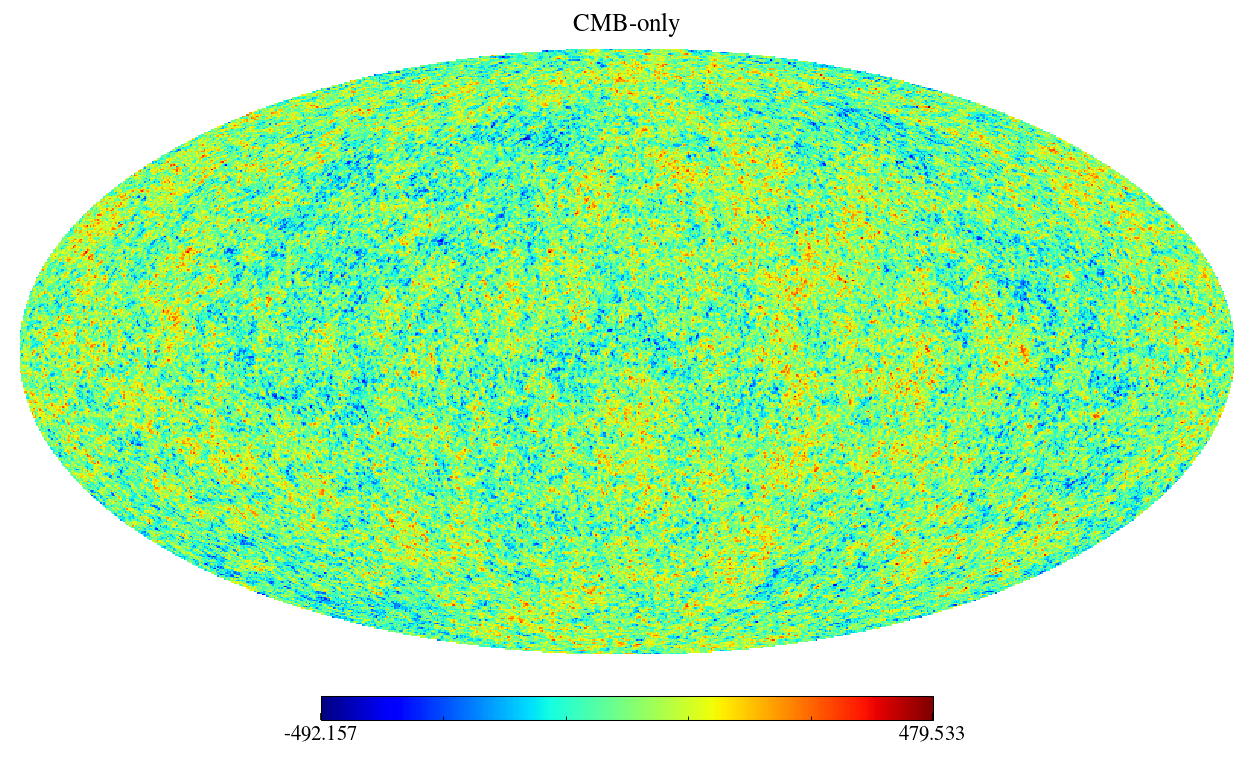

In [14]:
#create CMB map now
cmb_map = H.synfast(cl_TT, nside = param_dict['nside'], lmax = param_dict['lmax'], verbose = verbose)
cmb_map_input = np.copy(cmb_map)
H.mollview(cmb_map, title = r'CMB-only')

Random seed is 269


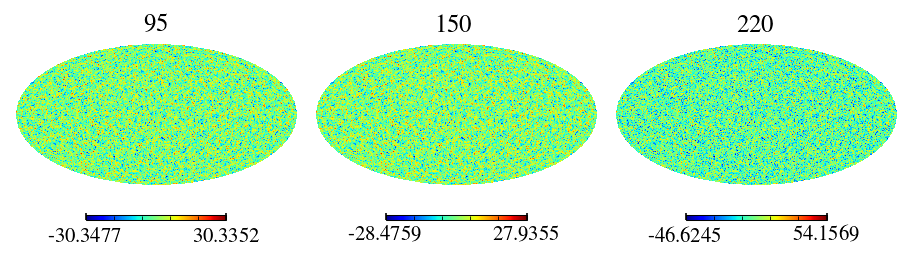

In [15]:
#create correlated foregrounds now
random_seed_fg = abs(int(cmb_map[0]))+1 ##834872
print('Random seed is %s' %(random_seed_fg))
fg_map_dic = {}
for fcnt, freq in enumerate( freqarr ):
    np.random.seed( random_seed_fg ) #correalted foregrounds
    fg_map = H.synfast(cl_fg_dic[freq], nside = param_dict['nside'], lmax = param_dict['lmax'], verbose = verbose)
    fg_map_dic[freq] = fg_map
    H.mollview(fg_map, title = r'%s' %(freq), sub = (1,3,fcnt+1))
    

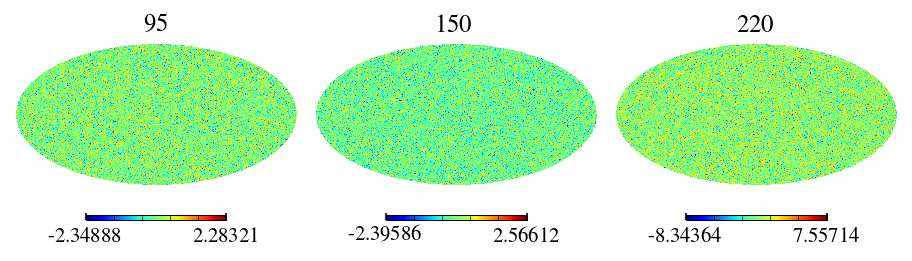

In [21]:
#create noise maps now
noise_map_dic = {}
for fcnt, freq in enumerate( freqarr ):
    beamval, noiseval = beam_noise_dic['T'][freq]
    noise_map = H.synfast(nl_dic['T'][freq], nside = param_dict['nside'], lmax = param_dict['lmax'], verbose = verbose)
    noise_map_dic[freq] = noise_map
    H.mollview(noise_map, title = r'%s' %(freq), sub = (1,3,fcnt+1))

In [22]:
#create combined maps now
map_dic = {}
for freq in freqarr:
    #combine CMB and FG
    cmb_fg_map_this_freq = np.copy(cmb_map) + fg_map_dic[freq]

    #Smooth
    beamval, noiseval = beam_noise_dic['T'][freq]
    cmb_fg_map_this_freq = H.smoothing(np.copy(cmb_fg_map_this_freq), fwhm = np.radians(beamval/60.), lmax = lmax, verbose = verbose)

    #add noise map to it
    map_dic[freq] = cmb_fg_map_this_freq + noise_map_dic[freq]

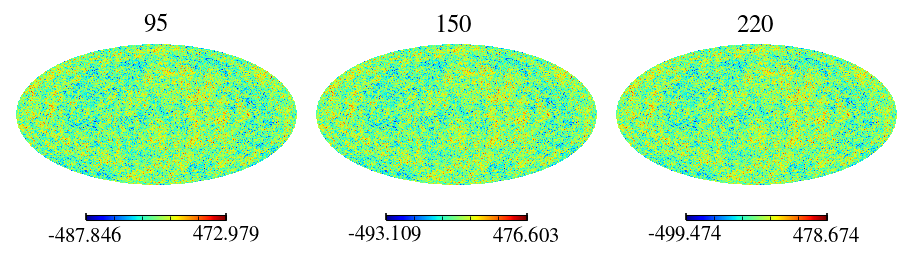

In [23]:
#show maps
for cntr, freq in enumerate( freqarr ):
    H.mollview(map_dic[freq], sub = (1, len(freqarr), cntr + 1), title = freq)

In [24]:
#get ILC map now
ilc_map, weightsarr = ilc.get_ilc_map(final_comp, el, map_dic, bl_dic, param_dict['nside'], param_dict['lmax'], lmin = param_dict['lmin'], cl_dic = cl_dic['T'], nl_dic = nl_dic['T'], ignore_fg = ignore_fg, full_sky = 1)

(-3.0, 3.0)

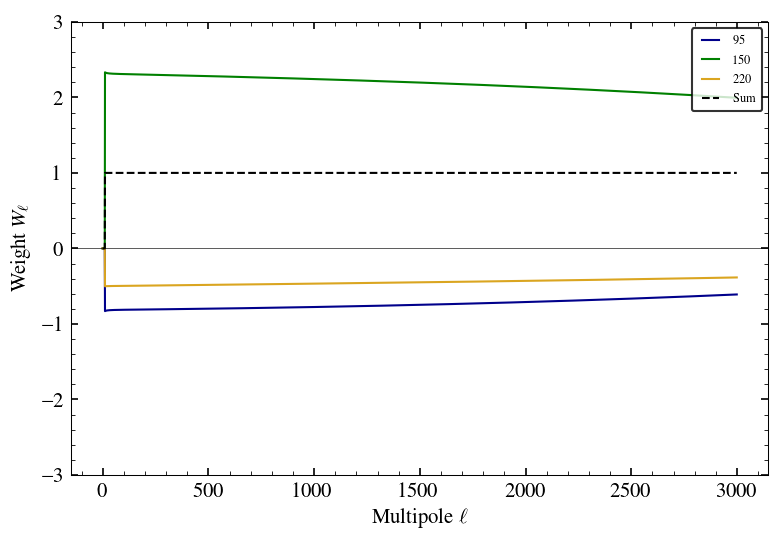

In [25]:
#plot weights now
for frqcntr, freq in enumerate( freqarr ):
    plot(weightsarr[frqcntr], color = colordic[freq], label = r'%s' %(freq))
plot(np.sum(weightsarr, axis = 0), 'k--', label = r'Sum')
axhline(lw=0.3)
legend(loc = 1, fontsize = 6)
xlabel(r'Multipole $\ell$')
ylabel(r'Weight $W_{\ell}$')
ylim(-3., 3.)

In [26]:
'''
#show maps
for cntr, freq in enumerate( freqs ):
    H.mollview(map_dic[freq], sub = (1, 5, cntr + 1), title = freq)    
H.mollview(cmb_map, sub = (1, 5, 4), title = r'Input CMB-only')
H.mollview(ilc_map, sub = (1, 5, 5), title = r'ILC')
#H.mollview(ilc_map, title = r'ILC')
'''

"\n#show maps\nfor cntr, freq in enumerate( freqs ):\n    H.mollview(map_dic[freq], sub = (1, 5, cntr + 1), title = freq)    \nH.mollview(cmb_map, sub = (1, 5, 4), title = r'Input CMB-only')\nH.mollview(ilc_map, sub = (1, 5, 5), title = r'ILC')\n#H.mollview(ilc_map, title = r'ILC')\n"

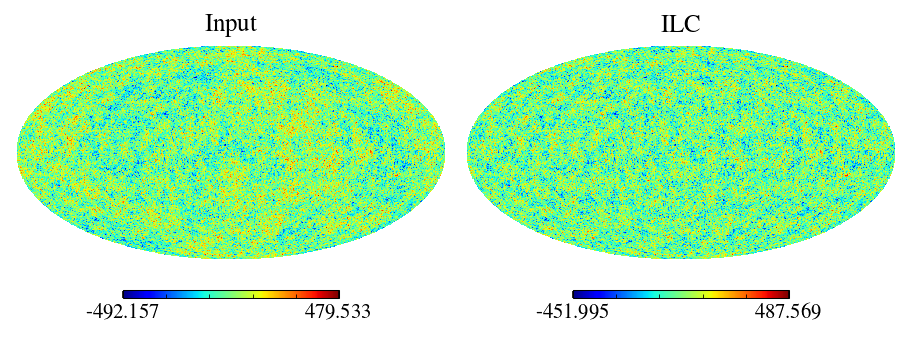

In [27]:
H.mollview(cmb_map_input, sub = (1,2,1), title = r'Input')
H.mollview(ilc_map, sub = (1,2,2), title = r'ILC')

In [28]:
#Cls of input and output
Cls_cross_ilc = H.anafast(ilc_map, lmax = lmax)
Cls_150 = H.anafast(map_dic[150], lmax = lmax)
Cls_cross_ip_op = H.anafast(cmb_map_input, ilc_map, lmax = lmax)

(0.1, 10000.0)

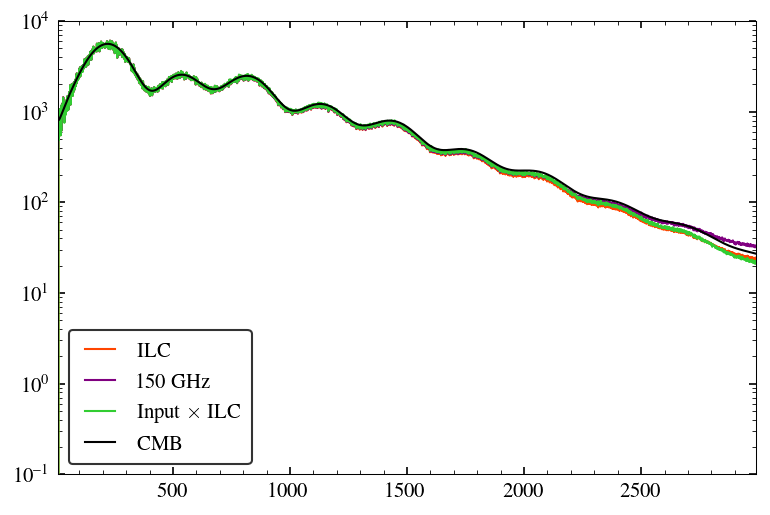

In [29]:
ax = subplot(111, yscale = 'log')#, xscale = 'log')
els_ = np.arange(len(Cls_cross_ilc))
Dls_fac = (els_ * (els_ + 1)) / 2 / np.pi
plot(Dls_fac * Cls_cross_ilc, 'orangered', label = r'ILC')
plot(Dls_fac * Cls_150, 'purple', label = r'150 GHz')
plot(Dls_fac * Cls_cross_ip_op, 'limegreen', label = r'Input $\times$ ILC')

Dls_fac = (el_camb * (el_camb + 1)) / 2 / np.pi
plot(el_camb, Dls_fac * cl_TT, 'k-', label = r'CMB')

legend(loc=3)
xlim(param_dict['lmin'], param_dict['lmax']-10); ylim(1e-1, 1e4)